In [1]:
import requests
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Define the stock symbols and prediction horizon
stock_symbols = ["AAPL", "GOOG", "MSFT"]  # Add more stock symbols as needed
prediction_horizon = "daily"

# Define the API key
api_key = "0FHEZ51MP59ZHZM0"
data = {}


for stock_symbol in stock_symbols:
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data[stock_symbol] = response.json()
        except ValueError as e:
            print(f"Error parsing JSON for {stock_symbol}: {e}")
    else:
        print(f"Failed to fetch data for {stock_symbol} with status code {response.status_code}")

# Initialize the MinMaxScaler
scaler = MinMaxScaler()
train_data = []
test_data = []

# Preprocess the data for each stock symbol
for stock_symbol in stock_symbols:
    try:
        # Transform JSON data to DataFrame
        df = pd.DataFrame(data[stock_symbol]["Time Series (Daily)"]).T
        df.columns = ['open', 'high', 'low', 'close', 'volume']
        df = df[['open', 'high', 'low', 'close']].astype(float)
        df["date"] = pd.to_datetime(df.index)
        df.set_index("date", inplace=True)
        df = df.sort_index()
        df_scaled = scaler.fit_transform(df)
        
        # Split data into training and testing sets
        train_size = int(0.8 * len(df_scaled))
        train_data.append(df_scaled[:train_size])
        test_data.append(df_scaled[train_size:])
    except KeyError as e:
        print(f"Data format error for {stock_symbol}: {e}")

    # Print the lengths of the data
    print(f"Length of {stock_symbol} data: {len(df_scaled)}")
    print(f"Train size: {train_size}")
    print(f"Test size: {len(df_scaled) - train_size}")


Length of AAPL data: 100
Train size: 80
Test size: 20
Length of GOOG data: 100
Train size: 80
Test size: 20
Length of MSFT data: 100
Train size: 80
Test size: 20


In [2]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_len):
        self.data = data
        self.sequence_len = sequence_len

    def __len__(self):
        return len(self.data) - self.sequence_len

    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.sequence_len]
        label = self.data[idx + self.sequence_len, 3]  # Predicting the close price
        return {
            'sequence': torch.tensor(sequence).float(),
            'label': torch.tensor(label).float()
        }


Stock Symbol: AAPL
Train RMSE: 0.0098
Test RMSE: 0.3160
Stock Symbol: GOOG
Train RMSE: 0.0096
Test RMSE: 0.0557
Stock Symbol: MSFT
Train RMSE: 0.0151
Test RMSE: 0.2312


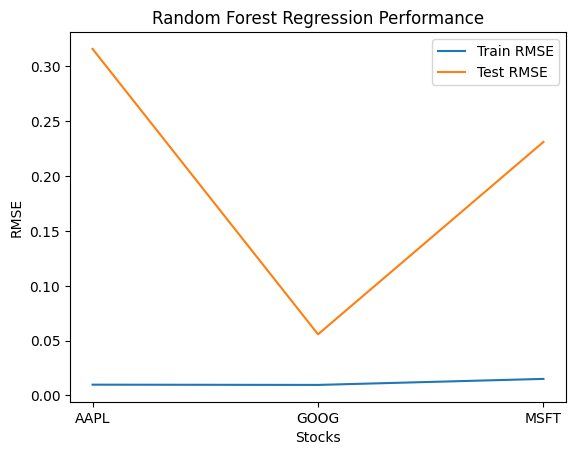

In [3]:
train_total_loss = []
test_total_loss = []

for idx, stock_symbol in enumerate(stock_symbols):
    # Prepare data
    X_train = train_data[idx][:, :-1]  # Use all columns except the last one as features
    y_train = train_data[idx][:, -1]   # Use the last column as the target (close price)
    X_test = test_data[idx][:, :-1]
    y_test = test_data[idx][:, -1]

    # Initialize Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate RMSE (Root Mean Squared Error)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    train_total_loss.append(train_rmse)
    test_total_loss.append(test_rmse)

    # Print RMSE for each stock
    print(f"Stock Symbol: {stock_symbol}")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print("="*30)

# Plot training and testing RMSE
plt.plot(train_total_loss, label='Train RMSE')
plt.plot(test_total_loss, label='Test RMSE')
plt.xlabel('Stocks')
plt.ylabel('RMSE')
plt.xticks(np.arange(len(stock_symbols)), stock_symbols)
plt.title('Random Forest Regression Performance')
plt.legend()
plt.show()


# Fine tuning

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm

In [5]:
# Assuming data collection and preprocessing steps have been completed

train_data = []
test_data = []

# Preprocess the data for each stock symbol (already done)

for stock_symbol in stock_symbols:
    # Process data and split into training and testing sets (already done)
    train_size = int(0.8 * len(df_scaled))
    train_data.append(df_scaled[:train_size])
    test_data.append(df_scaled[train_size:])


In [6]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],           # Number of trees in the forest
    'max_depth': [None, 10, 20],               # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]              # Minimum samples required to be at a leaf node
}


In [7]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

In [8]:
best_model = grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = best_model.best_params_
best_rf_model = best_model.best_estimator_

print(f"Best Parameters: {best_params}")

# Predictions
train_predictions = best_rf_model.predict(X_train)
test_predictions = best_rf_model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.1s
[CV] END max_d

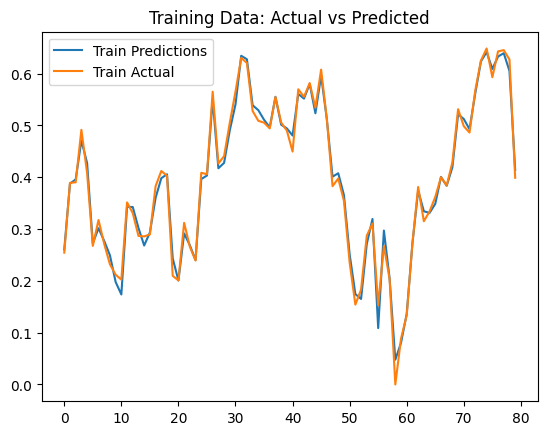

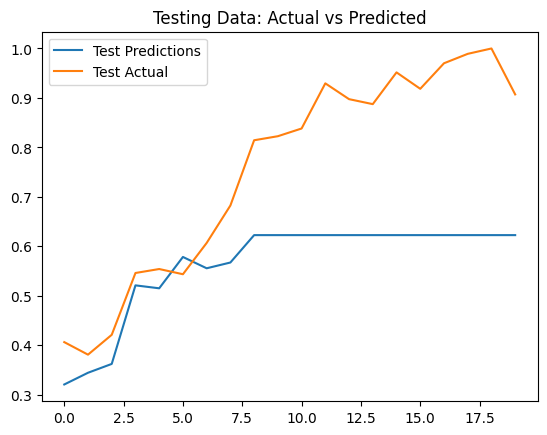

In [9]:
# Plotting
plt.plot(train_predictions, label='Train Predictions')
plt.plot(y_train, label='Train Actual')
plt.legend()
plt.title('Training Data: Actual vs Predicted')
plt.show()

plt.plot(test_predictions, label='Test Predictions')
plt.plot(y_test, label='Test Actual')
plt.legend()
plt.title('Testing Data: Actual vs Predicted')
plt.show()


In [10]:
from joblib import dump, load

# Export the model
model_filename = 'random_forest_model.joblib'
dump(best_rf_model, model_filename)

print(f"Model saved as {model_filename}")


Model saved as random_forest_model.joblib
